In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw
import matplotlib.pyplot as plt
import requests
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

# Notebook dependencies
from IPython.display import clear_output, Image

# Custom helpers package
from helpers import *

# For reloading the package
import importlib
import sys
importlib.reload(sys.modules['helpers'])
from helpers import *

# Set cuda gpu
device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')


device is cuda:0


In [2]:
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

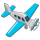

In [3]:
# CA Parameters

CHANNEL_N = 16
HIDDEN_SIZE = 128
PERCEPTION_SIZE = 48  # size of perception vector
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5
TARGET_PADDING = 16

# Don't even try pooling now

TARGET_EMOJI = "🛩"
target_img = load_emoji(TARGET_EMOJI)
imshow(target_img)

In [5]:
def pos_encoding(t, channels):
    """Encode time tensor using sinusoidal embedding"""
    inv_freq = 1.0 / (
        10000
        ** (torch.arange(0, channels, 2, device=device).float() / channels)
    )
    pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

# How to use the positional encoding:
t = torch.randint(low=1, high=1000, size=(8,)).to(device)
print(t.shape, t)
t = t.unsqueeze(-1).type(torch.float)
print(t.shape)
encoded_t = pos_encoding(t, 256)
print(encoded_t.shape)
encoded_t


torch.Size([8]) tensor([502, 124,  80, 270, 243, 861, 581, 887], device='cuda:0')
torch.Size([8, 1])
torch.Size([8, 256])


tensor([[-0.6090,  0.8135,  0.9224,  ...,  0.9981,  0.9983,  0.9985],
        [-0.9957,  0.7500,  0.5358,  ...,  0.9999,  0.9999,  0.9999],
        [-0.9939, -0.8148,  0.1614,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 0.2022, -0.1161, -0.8613,  ...,  0.9943,  0.9951,  0.9957],
        [ 0.1934,  0.3036,  0.4533,  ...,  0.9974,  0.9978,  0.9981],
        [ 0.8776,  0.7321,  1.0000,  ...,  0.9939,  0.9948,  0.9955]],
       device='cuda:0')

In [ ]:
class DiffusionCA:
    